## Chapter 3 -  ClassificatioN
## Precision-Recall plots, ROC plots, AUC-ROC Calculation

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             classification_report, 
                             confusion_matrix, f1_score, 
                             precision_recall_curve, roc_curve, roc_auc_score)
from sklearn.base import BaseEstimator

def load(fname):
    mnist = None
    try:
        with open(fname, 'rb') as f:
            mnist = pickle.load(f)
            return mnist
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        with open(fname, 'wb') as f:
            mnist = pickle.dump(mnist, f)
        return mnist

### Ingest

In [2]:
mnist_data = load('mnist.data.pkl')
X, y = mnist_data['data'], mnist_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Binary Classification - Classify "5" or "not 5"
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [3]:
# Create model, train & evaluate
sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In some contexts you prefer better precision, while in others, you prefer higher recall. You cannot have it both ways. A higher precision leads to a lower recall and vice versa. This is called the precision/recall tradeoff.

In [4]:
ypredscores = sgd_clf.decision_function(X_train)

In [5]:
# In SGD Classifer, you can access the decision function scores and then 
# decide the prediction result based on a preset threshold
threshold1 = 0
ypred31 = (ypredscores > threshold1)

print(confusion_matrix(y_train_5, ypred31)) 
print(precision_score(y_train_5, ypred31)) 
print(recall_score(y_train_5, ypred31))
print(f1_score(y_train_5, ypred31))

[[53882   229]
 [ 1911  3478]]
0.9382249797680065
0.6453887548710335
0.7647317502198768


In [6]:
threshold2 = 5000
ypred32 = (ypredscores > threshold2)

print(confusion_matrix(y_train_5, ypred32)) 
print(precision_score(y_train_5, ypred32)) 
print(recall_score(y_train_5, ypred32))
print(f1_score(y_train_5, ypred32))

[[54102     9]
 [ 4331  1058]]
0.9915651358950328
0.19632584895156802
0.3277571251548947


In [7]:
# Get precisions and recalls on different thresholds
y_cross_val_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_cross_val_scores)
prt_df = pd.DataFrame({'precision' : precisions[:-1], 'recall' : recalls[:-1], 'threshold' : thresholds})

(0.0, 1.0)

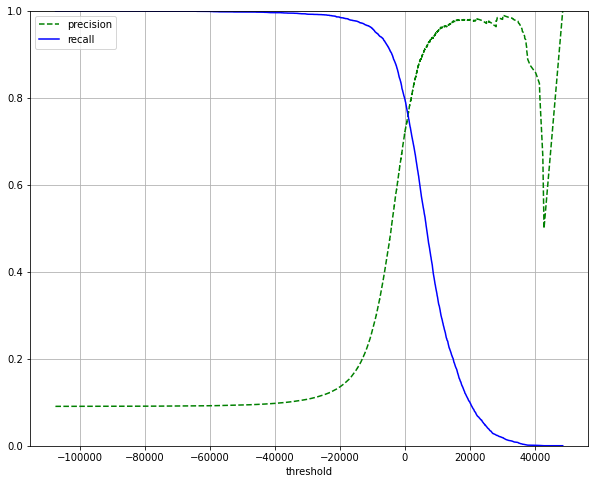

In [8]:
# Plot precision & recall against threshold
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
prt_df.plot(x='threshold', y='precision', ax=ax, color='green', style='--')
prt_df.plot(x='threshold', y='recall', ax=ax, color='blue', style='-')
ax.grid()
ax.set_ylim(0,1.0)

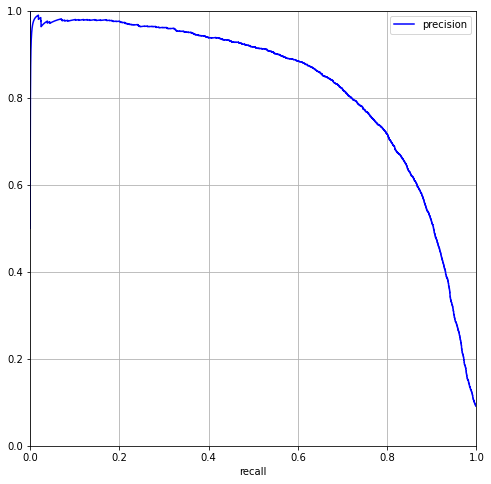

In [9]:
# Plot precision-recall curve
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
prt_df.plot(x='recall', y='precision', ax=ax, color='blue', style='-')
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.grid()
plt.show()

In [10]:
# Choose recall of 90%, t=5449.139113
prt_df[(prt_df.threshold>-4021.00)].head()

,precision,recall,threshold
49935,0.512090,0.899981,-4020.272795
49936,0.512144,0.899981,-4019.914100
49937,0.512198,0.899981,-4019.658970
49938,0.512252,0.899981,-4019.169564
49939,0.512306,0.899981,-4018.396023


In [11]:
# Pick a thredhold of about -4021
t3 = -4021.00
ypredscores = sgd_clf.decision_function(X_train)
ypredscores3 = (ypredscores > t3)

print(precision_score(y_train_5, ypredscores3)) 
print(recall_score(y_train_5, ypredscores3))

0.6841495218777166
0.8762293560957506


In [12]:
fpr, tpr, thresholds = roc_curve(y_train_5, ypredscores)
print(roc_auc_score(y_train_5, ypredscores))
roc_df = pd.DataFrame({'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds})

0.9700859259633587


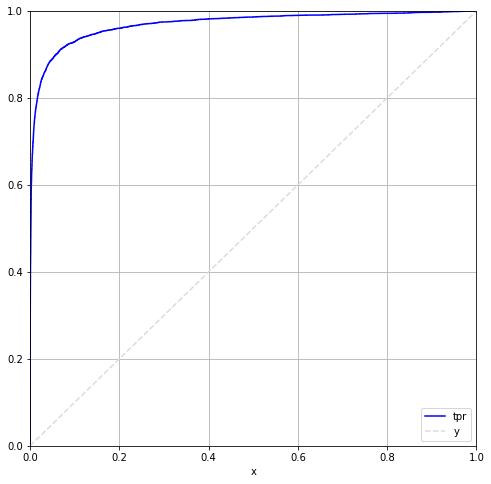

In [13]:
# Plot precision-recall curve
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
roc_df.plot(x='fpr', y='tpr', ax=ax, color='blue', style='-')
pd.DataFrame({'x' : [0.0, 1.0], 'y' : [0.0, 1.0]}).plot(x='x', y='y', style='--', color='GAINSBORO', ax=ax)
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.grid()
plt.show()

In [14]:
# Training a Random Forest Classifier for AUC ROC curve

In [15]:
forest_clf = RandomForestClassifier(random_state=0)
yprobas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [16]:
yforestscores = yprobas_forest[:,1]

0.9987717185630594


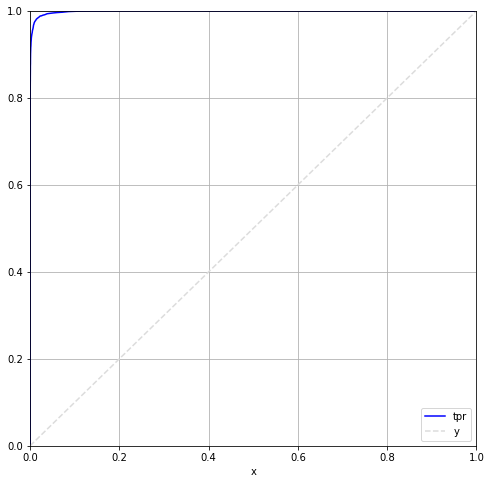

In [17]:
fpr2, tpr2, thresholds2 = roc_curve(y_train_5, yforestscores)
print(roc_auc_score(y_train_5, yforestscores))
roc_df2 = pd.DataFrame({'fpr' : fpr2, 'tpr' : tpr2, 'thresholds' : thresholds2})
# Plot precision-recall curve
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
roc_df2.plot(x='fpr', y='tpr', ax=ax, color='blue', style='-')
pd.DataFrame({'x' : [0.0, 1.0], 'y' : [0.0, 1.0]}).plot(x='x', y='y', style='--', color='GAINSBORO', ax=ax)
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.grid()
plt.show()

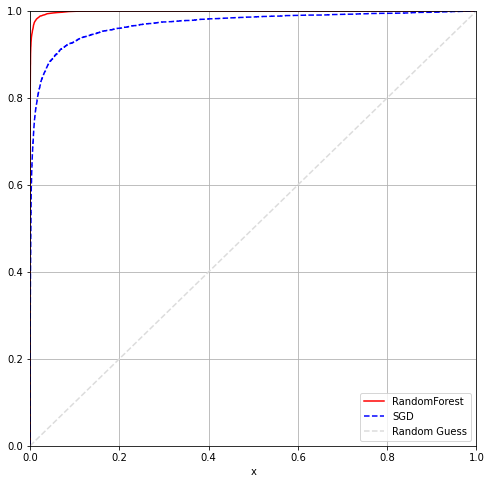

In [18]:
# Plot precision-recall curve
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
roc_df2.plot(x='fpr', y='tpr', ax=ax, color='red', style='-')
roc_df.plot(x='fpr', y='tpr', ax=ax, color='blue', style='--')
pd.DataFrame({'x' : [0.0, 1.0], 'y' : [0.0, 1.0]}).plot(x='x', y='y', style='--', color='GAINSBORO', ax=ax)
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.grid()
ax.legend(['RandomForest', 'SGD', 'Random Guess'])
plt.show()